In [6]:
import numpy as np
import pandas as pd

date1 = pd.to_datetime('20220820')
date2 = pd.to_datetime('20220821')
(date1 - date2).days

-1

设置定投频率为:7日,每次定投:255.87467362924284
总投资： 19369.71279373369
总收益： -1907.5334016464008
收益率:  -9.848021093340673 %


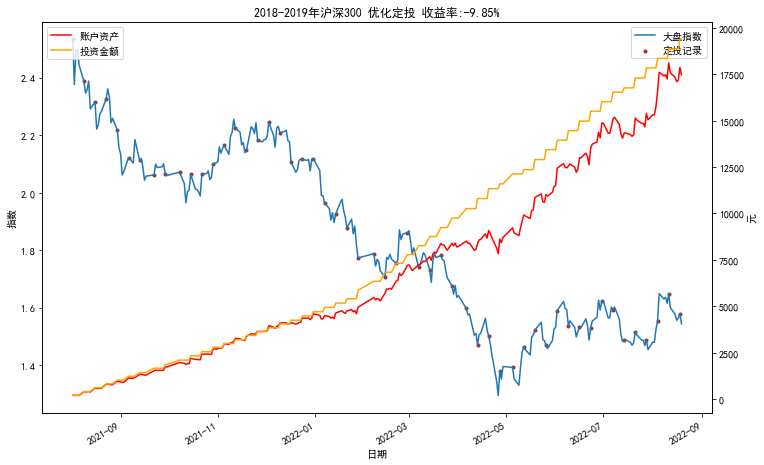

设置定投频率为:10日,每次定投:365.5352480417755
总投资： 18678.851174934716
总收益： -1767.5316541201191
收益率:  -9.462742850545233 %


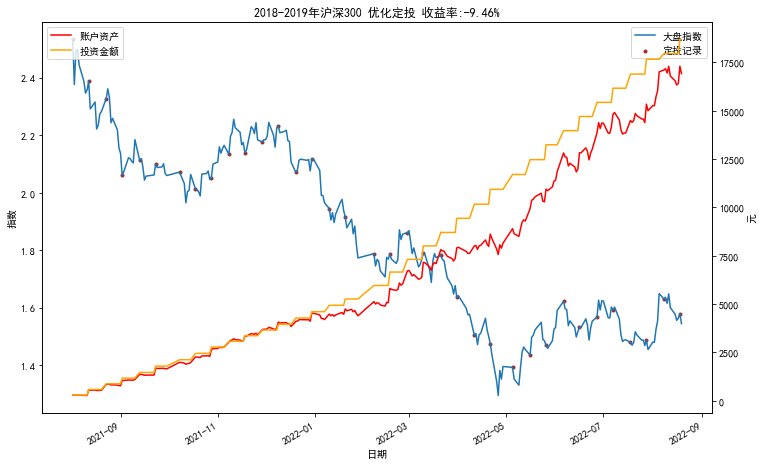

设置定投频率为:13日,每次定投:475.1958224543081
总投资： 17962.402088772844
总收益： -1803.3901628524225
收益率:  -10.0398051103622 %


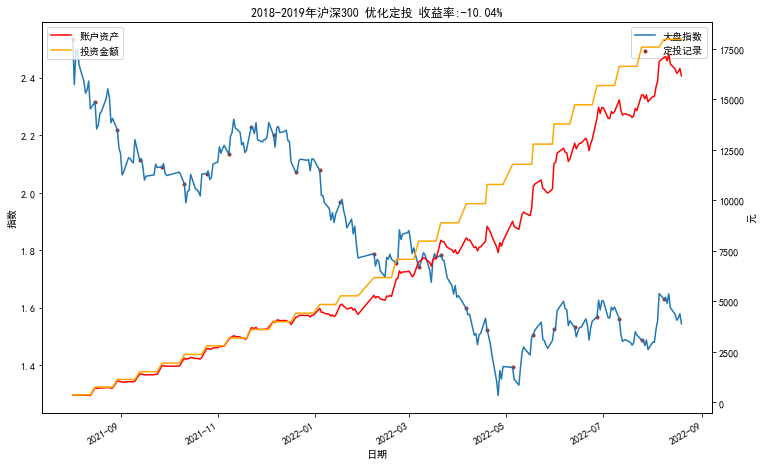

设置定投频率为:16日,每次定投:584.8563968668408
总投资： 18189.033942558748
总收益： -1871.1249403433362
收益率:  -10.287104561200874 %


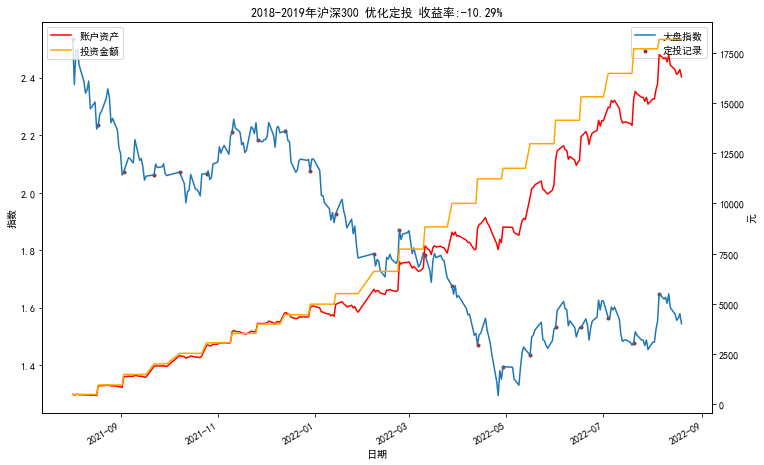

设置定投频率为:19日,每次定投:694.5169712793734
总投资： 18960.31331592689
总收益： -1809.4513160664433
收益率:  -9.543361894481366 %


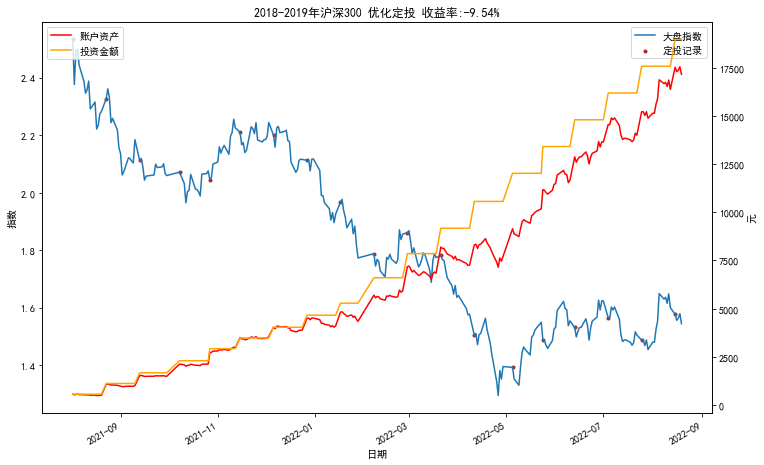

设置定投频率为:22日,每次定投:804.1775456919061
总投资： 19300.26109660574
总收益： -1972.6690931140472
收益率:  -10.220945111778683 %


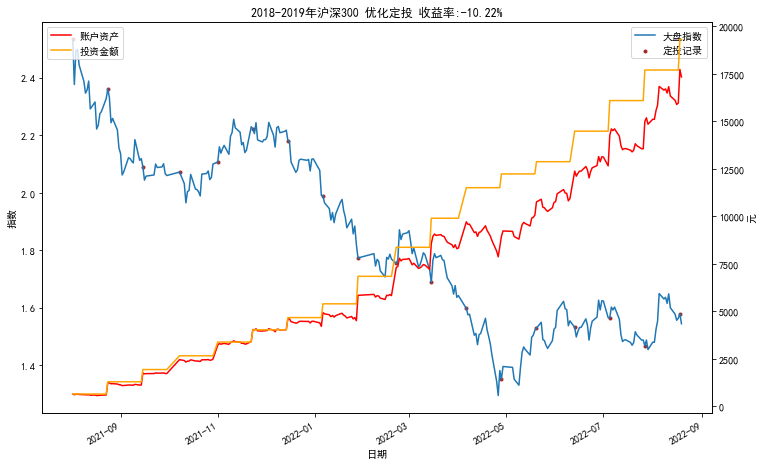

设置定投频率为:25日,每次定投:913.8381201044386
总投资： 17728.45953002611
总收益： -1882.4921046531285
收益率:  -10.618475347307044 %


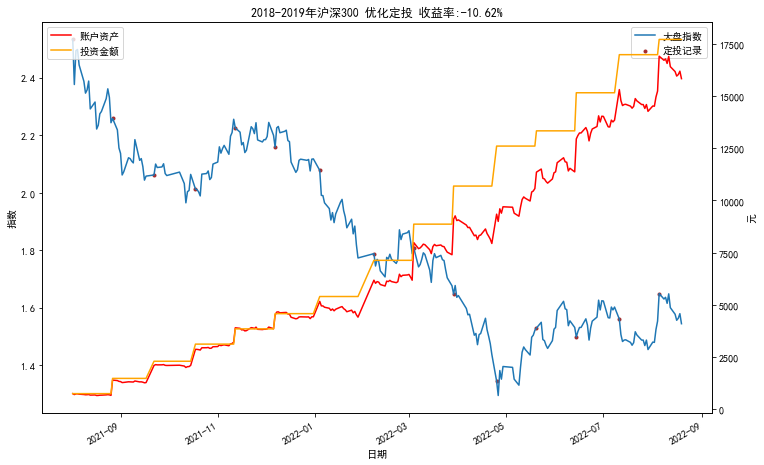

设置定投频率为:28日,每次定投:1023.4986945169713
总投资： 20572.323759791125
总收益： -1789.6045267637048
收益率:  -8.69908789915853 %


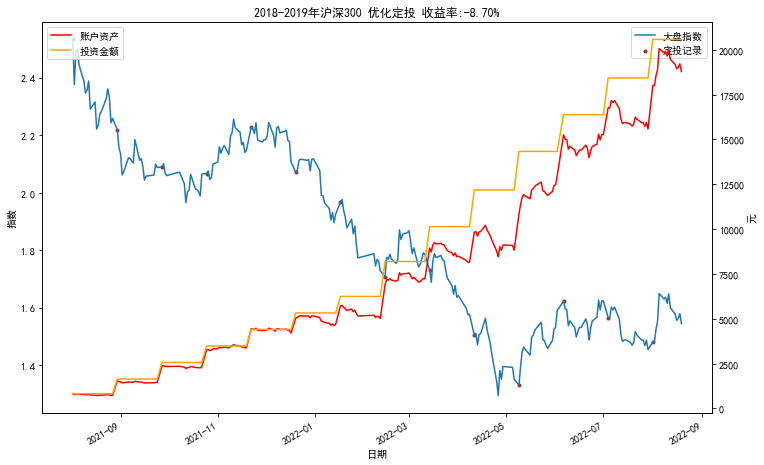

设置定投频率为:31日,每次定投:1133.159268929504
总投资： 21530.02610966057
总收益： -1773.4378589521018
收益率:  -8.237044627439428 %


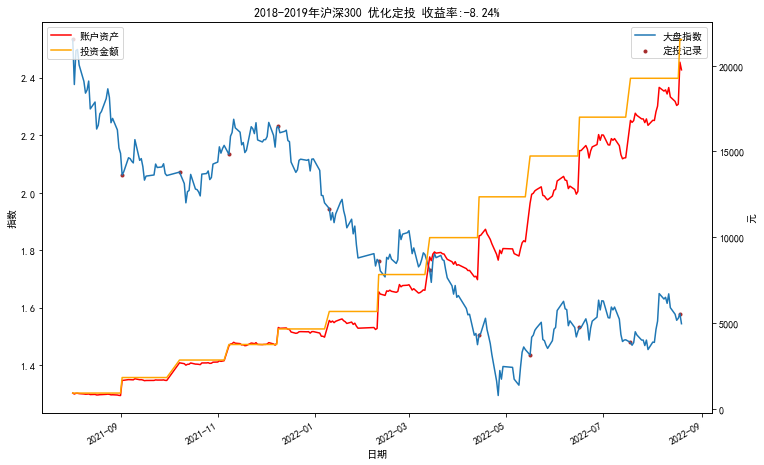

设置定投频率为:34日,每次定投:1242.8198433420366
总投资： 19760.835509138386
总收益： -1992.891585887221
收益率:  -10.085057309270196 %


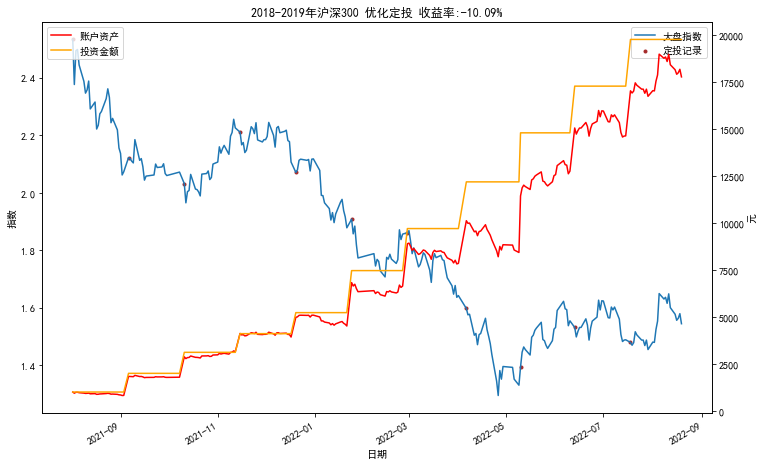

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
import execjs
import datetime
import time
from FundDataCrawler import FundDataCrawler


warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

fundDataCrawler = FundDataCrawler()
fundData = fundDataCrawler.getFund('320007')

endDate = '20220820'
startDate = '20210802'


def getData(start, end):
    '''
    获取指定时间范围内数据
    '''
    data = fundData.drop(fundData[fundData.index < pd.to_datetime(start)].index, axis=0, inplace=False)
    data.drop(data[data.index > pd.to_datetime(end)].index, axis=0, inplace=True)
    return data

def mean_days(df, days, wave):
    '''
     获取n日均线,最近m日振幅
    :param df: 数据集
    :param days: 均线天数
    :params wave:最近m日振幅
    :return average,wavelength:均线、近m日振幅
    '''
    average = []
    wavelength = []
    start = df.head(1).index-np.timedelta64(days+1, "D")
    start = start.astype('str')[0].replace("-", "")  # 转换为字符串

    df4 = getData(start, endDate)
    for i in df3.index:
        start_date = i-np.timedelta64(days+1, "D")
        ave = df4[(df4.index > start_date) & (df4.index < i)]['收盘价'].mean()
        average.append(ave)
    ########求振幅#######
    start2 = df.head(1).index-np.timedelta64(wave+1, "D")
    start2 = start2.astype('str')[0].replace("-", "")  # 转换为字符串
    df5 = getData(start2, endDate)

    for i in df3.index:
        start_date = i-np.timedelta64(wave+1, "D")
        interval = df5[(df5.index > start_date) & (df5.index < i)]['收盘价']
        length = interval.max()/interval.min()-1  # 最大涨跌幅
        wavelength.append(length)

    return average, wavelength


def stratege(ml, wl, T_1):
    '''
    定投策略
    :param ml:均线
    :param wl:振幅
    :param T_1:前1日收盘价
    '''
    cal = T_1/ml-1  # 大于0,则高于均线
    if (cal >= 0 and cal < 0.15):
        return 0.9
    elif (cal > 0.15 and cal < 0.5):
        return 0.8
    elif (cal >= 0.5 and cal < 1):
        return 0.7
    elif (cal >= 1):
        return 0.6

    elif (wl > 0.05):

        if (cal >= -0.05 and cal < 0):
            return 0.6
        elif (cal >= -0.1 and cal < -0.05):
            return 0.7
        elif (cal >= -0.2 and cal < -0.1):
            return 0.8
        elif (cal >= -0.3 and cal < -0.2):
            return 0.9
        elif (cal >= -0.4 and cal < -0.3):
            return 1.0
        elif (cal < -0.4):
            return 1.1
    else:
        if (cal >= -0.05 and cal < 0):
            return 1.8
        elif (cal >= -0.1 and cal < -0.05):
            return 1.9
        elif (cal >= -0.2 and cal < -0.1):
            return 2.0
        elif (cal >= -0.3 and cal < -0.2):
            return 2.1
        elif (cal >= -0.4 and cal < -0.3):
            return 2.2
        elif (cal < -0.4):
            return 2.3


def smart_invest(df1, frequence, invest_money, start_time, days, wave):
    '''
     定投计算
    :param df1: 数据集
    :param frequence: 定投频率
    :param invest_money: 每次定投金额
    :param start: 定投起始日期
    :param days: 参考均线天数

    :return (amount,invest_log): (收益数据DataFrame，定投记录dict)
    '''
    invest_log = {}  # 每次定投的日期记录(日期:大盘指数)
    invest_day = start_time  # 每次投资的时间
    invest_amount = 0  # 总投资金额
    profile = 0  # 总投资收益
    amount = 0  # 账户总资产

    profile_log = []  # 总收益日志
    invest_amount_log = []  # 账户投资金额日志
    amount_log = []  # 总资产日志
    Yield = []  # 收益率日志

    df1["均线"] = mean_days(df1, days, wave)[0]  # 获取均线
    df1["振幅"] = mean_days(df1, days, wave)[1]  # 获取振幅
    for date, quote_change, index, ml, wl in zip(df1.index, df1['涨跌幅'], df1['收盘价'], df1["均线"], df1["振幅"]):

        profile += quote_change*amount  # 计算当天收益率
        profile_log.append(profile)

        # 判断是否为定投日
        if date == invest_day:
            if (invest_day == start_time):
                T_1 = start_time
            else:
                formal_day = 1
                while (True):
                    T_1 = date-np.timedelta64(formal_day, "D")  # 前1天的收盘价
                    if (T_1 in df1.index.tolist()):
                        break
                    else:
                        formal_day += 1
            T_1 = df1[df1.index == T_1]["收盘价"][0]
            rate = stratege(ml, wl, T_1)
            invest_amount += invest_money*rate  # 定投
            invest_log[invest_day] = index  # 记录定投当日的指数

            # 判断7天后是否为交易日,如果不是则往后加1天直到找到交易日
            invest_day += np.timedelta64(frequence, 'D')
            flag = 0
            while (True):
                if (df1[df1.index == invest_day].index == invest_day):
                    break
                else:
                    invest_day += np.timedelta64(1, 'D')
                    flag += 1
                    if (flag == 100):
                        break

        invest_amount_log.append(invest_amount)
        amount = invest_amount+profile  # 更新账户总资产
        amount_log.append(amount)
        try:
            Yield.append(profile/invest_amount*100)  # 更新收益率
        except:
            Yield.append(0)
    print("总投资：", invest_amount)
    print("总收益：", profile)
    print("收益率: ", profile/invest_amount*100, "%")

    over = pd.DataFrame({
        "日期": df1.index,
        "收益率": Yield,
        "账户资产": amount_log,
        "投资金额": invest_amount_log
    })
    over = over.set_index("日期")
    return over, invest_log


def myplot(df1, res, buy, titlename):
    '''
    绘制定投结果图
    '''
    plt.figure()
    df1['收盘价'].plot(label="大盘指数")
    plt.scatter(buy.keys(), buy.values(),
                color="brown", marker=".", label="定投记录")
    plt.legend(loc='best')
    plt.ylabel("指数")
    plt.twinx()

    res['账户资产'].plot(color="red")
    res['投资金额'].plot(color="orange")
    plt.ylabel("元")
    plt.legend()
    plt.title(titlename+":{:.2f}%".format(res.tail(1)["收益率"][0]))
    plt.show()

df3 = getData(startDate, endDate)
total = 10000
for frequence in range(7,36,3):
    realDays = (pd.to_datetime(endDate) - pd.to_datetime(startDate)).days / 7 * 5
    invest_money = total / (realDays / frequence)  # 每次定投金额
    print("设置定投频率为:{}日,每次定投:{}".format(frequence,invest_money))
    res3, buy3 = smart_invest(df3, frequence, invest_money, pd.to_datetime(startDate), 500, 5)
    myplot(df3, res3, buy3, "2018-2019年沪深300 优化定投 收益率")